In [1]:
!pip install segmentation-models-pytorch wandb ttach


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
from PIL import Image

import polars as pl
import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Normalize

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from pathlib import Path
import random
import SimpleITK as sitk

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from skimage import measure
# import trimesh


import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp

from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold
import ttach
from collections.abc import Callable
import wandb

import math
import sys
from functools import partial

from segmentation_models_pytorch.decoders.unet.decoder import UnetDecoder
from segmentation_models_pytorch.base import SegmentationHead



In [32]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [33]:
try:
    from kaggle_secrets import UserSecretsClient

    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb-api-key")
    wandb.login(key=api_key)
except Exception as e:
    from decouple import config

    print("Could not log in to wandb:", e)
    api_key = config("WANDB_API_KEY")
    wandb.login(key=api_key)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Could not log in to wandb: No module named 'kaggle_secrets'


In [4]:
run = wandb.init(
    entity="newtonfractal-ukrainian-catholic-university",
    project="AI_HW3_CV_MRI_segmentation",
)

In [6]:
run.log({"test": 2.71})

# EDA

In [7]:
!ls /kaggle/input/mri-data-hw3

ls: /kaggle/input/mri-data-hw3: No such file or directory


In [5]:
# train_images_path = "/kaggle/input/mri-data-hw3/hw3_dataset/train"
train_images_path = "./data/hw3_dataset/train"

In [6]:
train_data_raw = (
    pl.read_csv(Path(train_images_path) / "train.csv")
    .with_columns(pl.col("day").cast(pl.Int32), pl.col("slice").cast(pl.Int32))
    .fill_null("")
)

In [7]:
len(train_data_raw)

17712

In [8]:
len(train_data_raw.select(pl.col("case"), pl.col("day")).unique())

41

In [9]:
41 * 144

5904

17712 segmentation masks, 5904 images

In [10]:
train_data_raw.head()

shape: (5, 5)
┌──────┬─────┬───────┬─────────────┬──────────────┐
│ case ┆ day ┆ slice ┆ class       ┆ segmentation │
│ ---  ┆ --- ┆ ---   ┆ ---         ┆ ---          │
│ i64  ┆ i32 ┆ i32   ┆ str         ┆ str          │
╞══════╪═════╪═══════╪═════════════╪══════════════╡
│ 46   ┆ 20  ┆ 1     ┆ large_bowel ┆              │
│ 46   ┆ 20  ┆ 1     ┆ small_bowel ┆              │
│ 46   ┆ 20  ┆ 1     ┆ stomach     ┆              │
│ 46   ┆ 20  ┆ 2     ┆ large_bowel ┆              │
│ 46   ┆ 20  ┆ 2     ┆ small_bowel ┆              │
└──────┴─────┴───────┴─────────────┴──────────────┘

From data I see that each image can have 1 of three organs: large bowel, small bowel and stomach.

In [11]:
train_data_raw.describe()

shape: (9, 6)
┌────────────┬───────────┬───────────┬───────────┬─────────────┬─────────────────────────────────┐
│ statistic  ┆ case      ┆ day       ┆ slice     ┆ class       ┆ segmentation                    │
│ ---        ┆ ---       ┆ ---       ┆ ---       ┆ ---         ┆ ---                             │
│ str        ┆ f64       ┆ f64       ┆ f64       ┆ str         ┆ str                             │
╞════════════╪═══════════╪═══════════╪═══════════╪═════════════╪═════════════════════════════════╡
│ count      ┆ 17712.0   ┆ 17712.0   ┆ 17712.0   ┆ 17712       ┆ 17712                           │
│ null_count ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0           ┆ 0                               │
│ mean       ┆ 29.365854 ┆ 13.780488 ┆ 72.5      ┆ null        ┆ null                            │
│ std        ┆ 20.674305 ┆ 11.284912 ┆ 41.569391 ┆ null        ┆ null                            │
│ min        ┆ 0.0       ┆ 0.0       ┆ 1.0       ┆ large_bowel ┆                                 │
│ 25%        ┆ 9.0       ┆ 0.0       ┆ 37.0      ┆ null        ┆ null                            │
│ 50%        ┆ 29.0      ┆ 18.0      ┆ 73.0      ┆ null        ┆ null                            │
│ 75%        ┆ 46.0      ┆ 22.0      ┆ 108.0     ┆ null        ┆ null                            │
│ max        ┆ 60.0      ┆ 36.0      ┆ 144.0     ┆ stomach     ┆ 9981 9 10214 1 10246 12 10477 … │
└────────────┴───────────┴───────────┴───────────┴─────────────┴─────────────────────────────────┘

In [12]:
len(train_data_raw.filter(pl.col("segmentation").eq("")))

12437

In [13]:
train_data_raw["class"].unique()

shape: (3,)
Series: 'class' [str]
[
	"stomach"
	"large_bowel"
	"small_bowel"
]

In [14]:
train_data_raw = train_data_raw.with_columns(
    pl.col("segmentation").eq("").alias("is_empty")
)

Count number of images per case

In [15]:
train_data_by_case = train_data_raw.group_by("case", "day").agg(pl.col("slice").max())
print(
    f"Number of images per case+day, min: {train_data_by_case['slice'].min()}, mean: {train_data_by_case['slice'].mean()}, max: {train_data_by_case['slice'].max()}"
)

Number of images per case+day, min: 144, mean: 144.0, max: 144


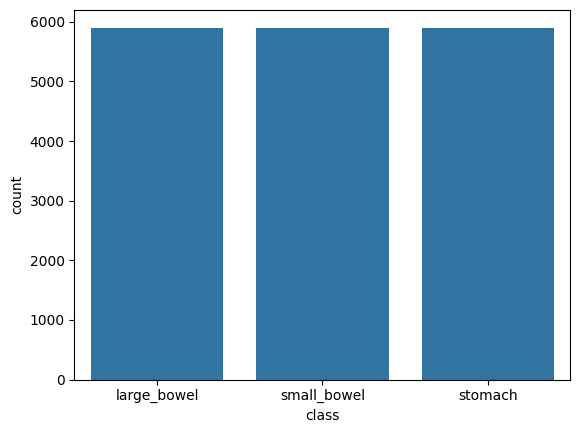

In [16]:
sns.countplot(x="class", data=train_data_raw.to_pandas())
plt.show()

In [17]:
all_train_images = Path("./data/hw3_dataset/train/").rglob("*.png")
all_test_images = Path("./data/hw3_dataset/test/").rglob("*.png")
dimensions = np.array(
    [
        np.array(Image.open(image_path)).shape
        for image_path in [*all_train_images, *all_test_images]
    ]
)

In [18]:
np.unique(dimensions, axis=0)

array([[266, 266],
       [276, 276],
       [310, 360]])

## Data Reading and Preprocessing

In [19]:
def rle_to_mask(rle: str, height: int, width: int) -> np.ndarray:
    s = list(map(int, rle.split()))
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((height, width))

In [20]:
def mask_to_rle(mask: np.ndarray) -> str:
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)

In [21]:
def get_image_and_masks(
    data: pl.DataFrame, case: int, day: int, slice: int, images_path: str
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    image_masks = (
        data.filter(
            pl.col("case").eq(case) & pl.col("day").eq(day) & pl.col("slice").eq(slice)
        )
        .group_by("case", "day", "slice")
        .agg(pl.col("class"), pl.col("segmentation"))
        .explode("class", "segmentation")
    )

    image = np.array(
        Image.open(f"{images_path}/case{case}/day{day}/slice_{slice}.png"),
        dtype=np.float32,
    )

    large_bowel_rle = image_masks.filter(pl.col("class").eq("large_bowel"))[
        "segmentation"
    ][0]

    small_bowel_rle = image_masks.filter(pl.col("class").eq("small_bowel"))[
        "segmentation"
    ][0]

    stomach_rle = image_masks.filter(pl.col("class").eq("stomach"))["segmentation"][0]

    return (
        image,
        rle_to_mask(large_bowel_rle, *image.shape),
        rle_to_mask(small_bowel_rle, *image.shape),
        rle_to_mask(stomach_rle, *image.shape),
    )

In [22]:
def preprocess_mri(image_uint16: np.ndarray) -> np.ndarray:
    image = image_uint16.astype(np.float32)

    # image = (image - image.min()) / (image.max() - image.min() + 1e-8)
    image /= image.max()

    return image

Augmentations below were kindly shared by Yaroslav Prytula with me.

In [23]:
def get_train_augmentations(img_size=(288, 288)) -> A.Compose:
    train_tfms = A.Compose(
        [
            # pad to max size
            A.LongestMaxSize(max_size=max(img_size)),
            A.PadIfNeeded(*img_size, border_mode=cv2.BORDER_CONSTANT, fill=0),
            A.RandomScale(scale_limit=(-0.2, 0.5), p=1, interpolation=1),
            A.PadIfNeeded(*img_size, border_mode=cv2.BORDER_CONSTANT, fill=0),
            A.RandomCrop(*img_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=1),
        ]
    )

    return train_tfms


In [24]:
def get_test_augmentations(img_size=(288, 288)) -> A.ReplayCompose:
    valid_tfms = A.ReplayCompose(
        [
            A.LongestMaxSize(max_size=max(img_size)),
            A.PadIfNeeded(*img_size, border_mode=cv2.BORDER_CONSTANT, fill=0),
        ]
    )

    return valid_tfms


Those are taken from this [notebook](https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch#%F0%9F%94%8D-Optimizer)

In [25]:
def get_improved_train_augmentations(img_size=(288, 288)) -> A.Compose:
    train_tfms = A.Compose(
        [
            A.LongestMaxSize(max_size=max(img_size)),
            A.PadIfNeeded(*img_size, border_mode=cv2.BORDER_CONSTANT, fill=0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=1),
            A.ShiftScaleRotate(
                shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5
            ),
            A.OneOf(
                [
                    A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                    A.ElasticTransform(alpha=1, sigma=50, p=1.0),
                ],
                p=0.25,
            ),
            A.RandomCrop(*img_size),
        ]
    )

    return train_tfms

## 2D Visualization

0.0 1.0
(266, 266) float32


/Users/vitya/Documents/AI homeworks/HW3-CV/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:132: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


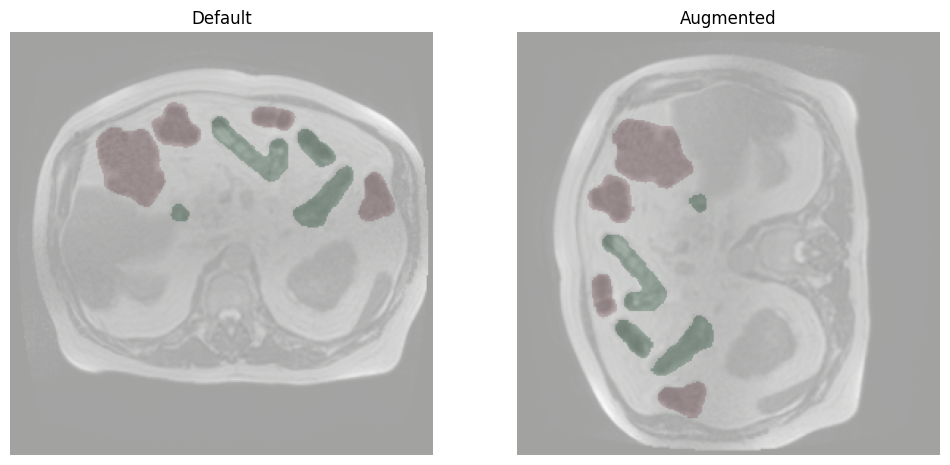

In [26]:
random_sample = train_data_raw.sample(n=1)

image, large_bowel_mask, small_bowel_mask, stomach_mask = get_image_and_masks(
    train_data_raw,
    random_sample["case"][0],
    random_sample["day"][0],
    random_sample["slice"][0],
    train_images_path,
)
image = preprocess_mri(image)


print(np.min(image), np.max(image))
print(image.shape, image.dtype)

augmented = get_improved_train_augmentations()(
    image=image,
    mask=np.stack([large_bowel_mask, small_bowel_mask, stomach_mask], axis=-1),
)
aug_image = augmented["image"]
aug_masks = augmented["mask"]

aug_large_bowel_mask = aug_masks[..., 0]
aug_small_bowel_mask = aug_masks[..., 1]
aug_stomach_mask = aug_masks[..., 2]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))


axes[0].imshow(image, cmap="gray")
axes[0].imshow(large_bowel_mask, cmap="Reds", alpha=0.3)
axes[0].imshow(small_bowel_mask, cmap="Greens", alpha=0.3)
axes[0].imshow(stomach_mask, cmap="Blues", alpha=0.3)
axes[0].set_title("Default")
axes[0].axis("off")

axes[1].imshow(aug_image, cmap="gray")
axes[1].imshow(aug_large_bowel_mask, cmap="Reds", alpha=0.3)
axes[1].imshow(aug_small_bowel_mask, cmap="Greens", alpha=0.3)
axes[1].imshow(aug_stomach_mask, cmap="Blues", alpha=0.3)
axes[1].set_title("Augmented")
axes[1].axis("off")

plt.show()


In [25]:
def plot_image_and_mask(image: np.ndarray, mask: np.ndarray) -> None:
    plt.imshow(image, cmap="gray")

    large_bowel_mask = mask[..., 0]
    small_bowel_mask = mask[..., 1]
    stomach_mask = mask[..., 2]

    plt.imshow(large_bowel_mask, cmap="Reds", alpha=0.3)
    plt.imshow(small_bowel_mask, cmap="Greens", alpha=0.3)
    plt.imshow(stomach_mask, cmap="Blues", alpha=0.3)

    plt.axis("off")
    plt.show()

## 3D Visuals

There is separate import for trimesh as there are some bizzare dependency issues when I try to install it in colab or kaggle notebooks.

In [41]:
import trimesh

In [42]:
def get_3d_data(
    data: pl.DataFrame, case: int, day: int, images_path: str
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    data_filtered = data.filter(pl.col("case").eq(case) & pl.col("day").eq(day))

    image_masks_3d = np.array(
        [
            get_image_and_masks(data_filtered, case, day, slice_, images_path)
            for slice_ in range(1, data_filtered["slice"].max() + 1)
        ]
    )

    return (
        image_masks_3d[:, 0],
        image_masks_3d[:, 1],
        image_masks_3d[:, 2],
        image_masks_3d[:, 3],
    )


In [43]:
_, large_bowel_mask_3d, small_bowel_mask_3d, stomach_mask_3d = get_3d_data(
    train_data_raw, 2, 0, train_images_path
)
verts, faces, normals, values = measure.marching_cubes(large_bowel_mask_3d, level=0.5)
mesh_large_bowel = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)
mesh_large_bowel.show()

In [44]:
verts, faces, normals, values = measure.marching_cubes(small_bowel_mask_3d, level=0.5)
mesh_large_bowel = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)
mesh_large_bowel.show()

In [45]:
verts, faces, normals, values = measure.marching_cubes(stomach_mask_3d, level=0.5)
mesh_large_bowel = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)
mesh_large_bowel.show()

# Data Loader

In [46]:
def patient_wise_split(df: pl.DataFrame, val_ratio=0.2, seed=42):
    np.random.seed(seed)

    patients = df["case"].unique().to_list()
    np.random.shuffle(patients)

    n_val = int(len(patients) * val_ratio)
    val_patients = patients[:n_val]
    train_patients = patients[n_val:]

    train_df = df.filter(pl.col("case").is_in(train_patients))
    val_df = df.filter(pl.col("case").is_in(val_patients))

    return train_df, val_df

In [47]:
class MRISegmentationDataset(Dataset):
    def __init__(
        self,
        dataframe,
        images_path: str,
        preprocess_fn=None,
        augmentations=None,
        two_point_five_d: bool = False,
        depth: int = 3,
        return_original_shape: bool = False,
    ):
        self.dataframe = dataframe
        self.unique_samples = dataframe.select("case", "day", "slice").unique()
        self.preprocess_fn = preprocess_fn
        self.augmentations = augmentations
        self.images_path = images_path

        self.two_point_five_d = two_point_five_d
        self.depth = depth if depth % 2 == 1 else depth + 1
        self.return_original_shape = return_original_shape

    def __len__(self):
        return len(self.unique_samples)

    def __getitem__(self, idx):
        row = self.unique_samples[idx]
        case, day, slice_idx = (
            int(row["case"].item()),
            int(row["day"].item()),
            int(row["slice"].item()),
        )

        image, large_mask, small_mask, stomach_mask = get_image_and_masks(
            self.dataframe, case, day, slice_idx, self.images_path
        )

        if self.two_point_five_d:
            image = self._get_2p5d_stack(case, day, slice_idx)

        mask = np.stack([large_mask, small_mask, stomach_mask], axis=-1).astype(
            np.float32
        )

        if self.preprocess_fn:
            if self.two_point_five_d:
                image = np.stack([self.preprocess_fn(im) for im in image], axis=0)
            else:
                image = self.preprocess_fn(image)

        replay_data = None
        if self.augmentations:
            if self.two_point_five_d:
                image_hw_c = np.transpose(image, (1, 2, 0))
                augmented = self.augmentations(image=image_hw_c, mask=mask)
                image = np.transpose(augmented["image"], (2, 0, 1))
                mask = augmented["mask"]
                replay_data = augmented.get("replay", None)
            else:
                augmented = self.augmentations(image=image, mask=mask)
                image = augmented["image"]
                mask = augmented["mask"]
                replay_data = augmented.get("replay", None)

        mask = np.transpose(mask, (2, 0, 1))

        if image.ndim == 2:
            image = np.expand_dims(image, 0)

        image_tensor = torch.tensor(image, dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.float32)

        if self.return_original_shape:
            return image_tensor, mask_tensor, case, day, slice_idx, replay_data
        else:
            return image_tensor, mask_tensor, case, day, slice_idx

    def _get_2p5d_stack(self, case, day, center_slice_idx):
        half = self.depth // 2

        slices_df = (
            self.dataframe.filter(
                (self.dataframe["case"] == case) & (self.dataframe["day"] == day)
            )
            .select("slice")
            .unique()
            .sort("slice")
        )
        all_slices = slices_df["slice"].to_list()
        num_slices = len(all_slices)

        center_pos = all_slices.index(center_slice_idx)

        idxs = [
            all_slices[np.clip(center_pos + o, 0, num_slices - 1)]
            for o in range(-half, half + 1)
        ]

        images = []
        for s in idxs:
            im, _, _, _ = get_image_and_masks(
                self.dataframe, case, day, s, self.images_path
            )
            images.append(im)

        return np.stack(images, axis=0).astype(np.float32)

# Training
## Training Helpers


In [48]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, device, scheduler=None):
    model.train()
    epoch_loss = 0.0

    print("Training one epoch")
    pbar = tqdm(train_loader, desc="Train ")
    for batch in pbar:
        images, masks, *_ = batch

        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    return epoch_loss

Coefficient functions are taken from this [notebook](https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch#%F0%9F%94%8D-Optimizer)

In [49]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2, 3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred > thr).to(torch.float32)
    inter = (y_true * y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2 * inter + epsilon) / (den + epsilon)).mean(dim=(1, 0))
    return dice

In [50]:
def iou_coef(y_true, y_pred, thr=0.5, dim=(2, 3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred > thr).to(torch.float32)
    inter = (y_true * y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true * y_pred).sum(dim=dim)
    iou = ((inter + epsilon) / (union + epsilon)).mean(dim=(1, 0))
    return iou

In [51]:
def evaluate(model, val_loader, device, thr: float = 0.5):
    model.eval()
    dices = []
    ious = []

    print("Evaluating model")
    with torch.no_grad():
        for batch in tqdm(val_loader):
            images, masks, *_ = batch
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            outputs_soft = torch.sigmoid(outputs)

            dice = dice_coef(masks, outputs_soft, thr).cpu()
            iou = iou_coef(masks, outputs_soft, thr).cpu()
            ious.append(iou)
            dices.append(dice)

    return np.array(dices).mean(), np.array(ious).mean()


In [52]:
train_df, val_df = patient_wise_split(train_data_raw, val_ratio=0.2)

train_data = MRISegmentationDataset(
    train_df,
    train_images_path,
    preprocess_mri,
    get_train_augmentations(),
    two_point_five_d=True,
    depth=5,
)
val_data = MRISegmentationDataset(
    val_df,
    train_images_path,
    preprocess_mri,
    get_test_augmentations(),
    two_point_five_d=True,
    depth=5,
)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)

mps


In [54]:
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, bce_weight=0.5):
        super().__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.dice_loss = smp.losses.DiceLoss(mode="multilabel")
        self.bce_loss = smp.losses.SoftBCEWithLogitsLoss()

    def forward(self, outputs, targets):
        dice = self.dice_loss(outputs, targets)
        bce = self.bce_loss(outputs, targets)
        return self.dice_weight * dice + self.bce_weight * bce

## Model 2
ResNet as backbone + Unet.

In [ ]:
ENCODER = "resnet50"
ENCODER_WEIGHTS = "imagenet"
IN_CHANNELS = 5
NUM_CLASSES = 3
LR = 1e-3
WEIGHT_DECAY = 1e-6

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=IN_CHANNELS,
    classes=NUM_CLASSES,
    activation=None,
)
model = model.to(device)


loss_fn = CombinedLoss(dice_weight=0.5, bce_weight=0.5).to(device)

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [133]:
num_epochs = 2

In [134]:
print("Starting training")
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    val_dice, val_iou = evaluate(model, val_loader, device)

    print(
        f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}"
    )

Starting training
Training one epoch


Train : 100%|██████████| 630/630 [04:01<00:00,  2.61it/s]


Evaluating model


100%|██████████| 108/108 [00:19<00:00,  5.55it/s]


Epoch 1/2 | Train Loss: 0.4276 | Val Dice: 0.5561 | Val IoU: 0.5296
Training one epoch


Train : 100%|██████████| 630/630 [04:05<00:00,  2.57it/s]


Evaluating model


100%|██████████| 108/108 [00:18<00:00,  5.70it/s]

Epoch 2/2 | Train Loss: 0.3825 | Val Dice: 0.4532 | Val IoU: 0.4080


# Cross-validation setup

In [55]:
FOLDS_NUM = 4

In [56]:
skf = StratifiedGroupKFold(n_splits=FOLDS_NUM, shuffle=True, random_state=42)
train_data_raw_folded = train_data_raw.with_columns(pl.lit(-1).alias("fold"))

for fold, (train_idx, val_idx) in enumerate(
    skf.split(
        train_data_raw,
        train_data_raw["is_empty"],
        groups=train_data_raw["case"],
    )
):
    train_data_raw_folded = train_data_raw_folded.with_columns(
        pl.when(pl.arange(0, len(train_data_raw)).is_in(val_idx))
        .then(fold)
        .otherwise(pl.col("fold"))
        .alias("fold")
    )


train_data_raw_folded.group_by(["fold", "is_empty"]).agg(pl.count()).sort(
    "fold", "is_empty"
)


/var/folders/3z/db289jnj3cdd97p1_ybqywr00000gn/T/ipykernel_13616/3376633430.py:19: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  train_data_raw_folded.group_by(["fold", "is_empty"]).agg(pl.count()).sort(


shape: (8, 3)
┌──────┬──────────┬───────┐
│ fold ┆ is_empty ┆ count │
│ ---  ┆ ---      ┆ ---   │
│ i32  ┆ bool     ┆ u32   │
╞══════╪══════════╪═══════╡
│ 0    ┆ false    ┆ 878   │
│ 0    ┆ true     ┆ 2578  │
│ 1    ┆ false    ┆ 1305  │
│ 1    ┆ true     ┆ 2583  │
│ 2    ┆ false    ┆ 2213  │
│ 2    ┆ true     ┆ 5131  │
│ 3    ┆ false    ┆ 879   │
│ 3    ┆ true     ┆ 2145  │
└──────┴──────────┴───────┘

Getter of data loader for fold

In [57]:
def get_data_loaders(
    full_dataset: pl.DataFrame,
    fold: int,
    two_point_five_d: bool = False,
    depth: int = 3,
    batch_size: int = 8,
    augmentations: Callable = get_train_augmentations,
) -> tuple[DataLoader, DataLoader]:
    train_dataframe = full_dataset.filter(pl.col("fold").ne(fold))
    val_dataframe = full_dataset.filter(pl.col("fold").eq(fold))

    train_data = MRISegmentationDataset(
        train_dataframe,
        images_path=train_images_path,
        preprocess_fn=preprocess_mri,
        augmentations=augmentations(),
        two_point_five_d=two_point_five_d,
        depth=depth,
    )
    val_data = MRISegmentationDataset(
        val_dataframe,
        images_path=train_images_path,
        preprocess_fn=preprocess_mri,
        augmentations=get_test_augmentations(),
        two_point_five_d=two_point_five_d,
        depth=depth,
    )

    return DataLoader(train_data, batch_size=batch_size, shuffle=True), DataLoader(
        val_data, batch_size=batch_size, shuffle=False
    )

In [58]:
class EarlyStopping:
    def __init__(self, patience=5, mode="max", delta=1e-4, save_path=None):
        self.patience = patience
        self.mode = mode
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.save_path = Path(save_path) if save_path else None

    def __call__(self, current_score, model):
        if self.best_score is None:
            self.best_score = current_score
            if self.save_path:
                torch.save(model.state_dict(), self.save_path)
                if wandb.run:
                    art = wandb.Artifact(f"model-{wandb.run.name}", type="model")
                    art.add_file(str(self.save_path))
                    wandb.log_artifact(art)
            return False

        improvement = (
            current_score > self.best_score + self.delta
            if self.mode == "max"
            else current_score < self.best_score - self.delta
        )

        if improvement:
            self.best_score = current_score
            self.counter = 0
            if self.save_path:
                torch.save(model.state_dict(), self.save_path)
                if wandb.run:
                    art = wandb.Artifact(f"model-{wandb.run.name}", type="model")
                    art.add_file(str(self.save_path))
                    wandb.log_artifact(art)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop


In [59]:
def run_training(
    full_data: pl.DataFrame,
    model_builder,
    device,
    augmentations: Callable = get_train_augmentations,
    epochs: int = 50,
    save_model_path: str = "models",
    model_name: str = "undefined",
    patience: int = 5,
    two_point_five_d: bool = False,
    depth: int = 3,
    batch_size: int = 8,
    scheduler_type: str = "onecycle",  # 'onecycle', 'cosine', 'step', 'none'
):
    models, loss_fns, optimizers = model_builder(device)

    save_dir = Path(save_model_path) / model_name
    save_dir.mkdir(exist_ok=True, parents=True)

    for fold in range(FOLDS_NUM):
        wandb.init(
            project="AI_HW3_CV_MRI_segmentation",
            name=f"{model_name}_fold{fold}",
            group=model_name,
            config={
                "model_name": model_name,
                "fold": fold,
                "epochs": epochs,
                "batch_size": batch_size,
                "patience": patience,
                "scheduler": scheduler_type,
            },
        )
        print(f"Training fold {fold}")
        model = models[fold]
        loss_fn = loss_fns[fold]
        optimizer = optimizers[fold]
        wandb.watch(model, log="all", log_freq=100)

        train_loader, val_loader = get_data_loaders(
            full_data,
            fold,
            two_point_five_d=two_point_five_d,
            depth=depth,
            batch_size=batch_size,
            augmentations=augmentations,
        )
        early_stopping = EarlyStopping(
            patience=patience, mode="max", save_path=save_dir / f"fold_{fold}.pth"
        )
        scheduler = None
        if scheduler_type == "onecycle":
            scheduler = optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=optimizer.param_groups[0]["lr"] * 10,
                epochs=epochs,
                steps_per_epoch=len(train_loader),
                pct_start=0.3,
                anneal_strategy="cos",
            )
        elif scheduler_type == "cosine":
            scheduler = optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=epochs,
                eta_min=1e-6,
            )
        elif scheduler_type == "step":
            scheduler = optim.lr_scheduler.StepLR(
                optimizer,
                step_size=max(1, epochs // 3),
                gamma=0.1,
            )

        print(f"Starting training with {scheduler_type} scheduler")
        for epoch in range(1, epochs + 1):
            train_loss = train_one_epoch(
                model,
                train_loader,
                loss_fn,
                optimizer,
                device,
                scheduler if scheduler_type == "onecycle" else None,
            )
            val_dice, val_iou = evaluate(model, val_loader, device)

            if scheduler is not None and scheduler_type in ["cosine", "step"]:
                scheduler.step()
                current_lr = optimizer.param_groups[0]["lr"]
                print(
                    f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f} | LR: {current_lr:.6f}"
                )
            else:
                print(
                    f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}"
                )

            if early_stopping(val_dice, model):
                print(f"Early stopping at epoch {epoch}")
                break

    return models

# Saving sumbission helpers

In [60]:
def dir_to_dataframe(test_dir: str) -> pl.DataFrame:
    records = []

    test_dir = Path(test_dir)

    for case_dir in sorted(test_dir.iterdir()):
        if not case_dir.is_dir():
            continue
        case_id = int(case_dir.name.replace("case", ""))

        for day_dir in sorted(case_dir.iterdir()):
            if not day_dir.is_dir():
                continue
            day_id = int(day_dir.name.replace("day", ""))

            for slice_file in sorted(day_dir.iterdir()):
                if not slice_file.suffix.lower() in [".png", ".jpg"]:
                    continue
                slice_num = int(slice_file.stem.replace("slice_", ""))
                for cls in ["large_bowel", "small_bowel", "stomach"]:
                    records.append(
                        {
                            "case": case_id,
                            "day": day_id,
                            "slice": slice_num,
                            "class": cls,
                            "segmentation": "",  # empty for now
                        }
                    )

    df = pl.DataFrame(records)
    return df

In [61]:
# len(list(Path("/kaggle/input/mri-data-hw3/hw3_dataset/test").rglob("*png*")))
len(list(Path("./data/hw3_dataset/test").rglob("*png*")))

9760

In [62]:
test_data_path = "./data/hw3_dataset/test"
test_data_raw = dir_to_dataframe(test_data_path)
test_dataset = MRISegmentationDataset(
    test_data_raw,
    test_data_path,
    preprocess_fn=preprocess_mri,
    augmentations=get_test_augmentations(),
)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [63]:
submission_template = pl.read_csv("./data/hw3_dataset/sample_submission.csv")

In [64]:
def segmentation_collate(batch):
    images, masks, cases, days, slice_idxs, replays = zip(*batch)

    images = torch.stack(images, dim=0)
    masks = torch.stack(masks, dim=0)

    replays = list(replays)

    return images, masks, cases, days, slice_idxs, replays

In [65]:
def post_process_mask(pred_mask, original_size, input_size=(288, 288)):
    H, W = original_size
    target_H, target_W = input_size

    scale = min(target_H / H, target_W / W)
    new_H, new_W = int(H * scale), int(W * scale)

    mask_original = cv2.resize(pred_mask, (W, H), interpolation=cv2.INTER_NEAREST)

    return mask_original

In [66]:
def predict_rle_from_loader(
    models: list,
    dataframe_raw: pl.DataFrame,
    dataloader,
    device,
    submission_template,
    threshold: float = 0.5,
    tta: bool = True,
    weights=None,
):
    if not isinstance(models, (list, tuple)):
        models = [models]

    if weights is None:
        weights = [1.0] * len(models)

    for i, m in enumerate(models):
        m.to(device)
        m.eval()
        if tta:
            models[i] = ttach.SegmentationTTAWrapper(
                m, ttach.aliases.d4_transform(), merge_mode="mean"
            )

    classes = ["large_bowel", "small_bowel", "stomach"]

    with torch.no_grad():
        for batch in tqdm(dataloader):
            if len(batch) == 6:
                images, _, case, day, slice, replay_data = batch
            else:
                images, _, case, day, slice = batch
                replay_data = None

            images = images.to(device)
            B = images.shape[0]

            probs_list = []
            for m in models:
                logits = m(images)
                probs = torch.sigmoid(logits)

                probs_list.append(probs)

            stacked = torch.stack(probs_list, dim=0)  # (M, B, C, H, W)

            weights_tensor = torch.tensor(
                weights, device=device, dtype=stacked.dtype
            ).view(-1, 1, 1, 1, 1)

            avg_probs = (stacked * weights_tensor).sum(
                dim=0
            ) / weights_tensor.sum()  # (B, C, H, W)

            preds = (avg_probs > threshold).to(torch.uint8).cpu().numpy()

            for i in range(B):
                for cls_idx in range(preds.shape[1]):
                    mask_padded = preds[i, cls_idx]

                    mask = post_process_mask(mask_padded, (266, 266))

                    rle = mask_to_rle(mask)

                    case_val = case[i]
                    day_val = day[i]
                    slice_val = slice[i]

                    id_ = f"case{case_val}_day{day_val}_slice_{str(slice_val).zfill(4)}_class_{classes[cls_idx]}"

                    submission_template = submission_template.with_columns(
                        pl.when(pl.col("id").eq(id_))
                        .then(pl.lit(rle))
                        .otherwise(pl.col("segmentation"))
                        .alias("segmentation")
                    )

    return submission_template

In [67]:
def load_saved_model(model_builder, path_to_models: str, device) -> list:
    models, _, _ = model_builder(device)
    for i, model_path in enumerate(Path(path_to_models).rglob("*.pth")):
        print(i, model_path)
        state_dict = torch.load(model_path, map_location=device)
        models[i].load_state_dict(state_dict)

    return models

In [68]:
def run_inference_pipeline(
    models,
    test_data_path: str,
    submission_template_path: str,
    device,
    threshold: float = 0.5,
    batch_size: int = 8,
    preprocess_fn=None,
    two_point_five_d: bool = False,
    depth: int = 3,
    tta: bool = True,
    weights=None,
):
    test_data_raw = dir_to_dataframe(test_data_path)

    test_dataset = MRISegmentationDataset(
        dataframe=test_data_raw,
        images_path=test_data_path,
        preprocess_fn=preprocess_fn or preprocess_mri,
        augmentations=get_test_augmentations(),
        # augmentations=None,
        two_point_five_d=two_point_five_d,
        depth=depth,
        return_original_shape=True,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=segmentation_collate,
    )

    submission_template = pl.read_csv(submission_template_path)

    df_submission = predict_rle_from_loader(
        models=models,
        dataframe_raw=test_data_raw,
        dataloader=test_loader,
        device=device,
        submission_template=submission_template,
        threshold=threshold,
        tta=tta,
        weights=weights,
    )

    return df_submission


# Real Experiments

---

## ResNet50 + UNet, KFold, 40epochs at most, fixed Loss, 2.5D

In [69]:
def build_resnet50_unet(device):
    ENCODER = "resnet50"
    ENCODER_WEIGHTS = "imagenet"
    IN_CHANNELS = 5
    NUM_CLASSES = 3
    LR = 1e-3
    WEIGHT_DECAY = 1e-6

    models = [
        smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=ENCODER_WEIGHTS,
            in_channels=IN_CHANNELS,
            classes=NUM_CLASSES,
            activation=None,
        ).to(device)
        for _ in range(FOLDS_NUM)
    ]

    loss_fns = [
        CombinedLoss(dice_weight=0.5, bce_weight=0.5).to(device)
        for _ in range(FOLDS_NUM)
    ]

    optimizers = [
        optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        for model in models
    ]

    return models, loss_fns, optimizers

In [ ]:
models_resnet50_unet = run_training(
    train_data_raw_folded,
    build_resnet50_unet,
    device,
    epochs=40,
    model_name="resnet50_unet_2.5D_depth5_40eps",
    save_model_path="models",
    two_point_five_d=True,
    depth=5,
    scheduler_type="cosine",
    augmentations=get_improved_train_augmentations,
)

In [ ]:
submission_resnet50_unet = run_inference_pipeline(
    models_resnet50_unet,
    test_data_path,
    "./data/hw3_dataset/sample_submission.csv",
    device,
    0.69,
    preprocess_fn=preprocess_mri,
)


In [ ]:
submission_resnet50_unet.write_csv(
    "submission_resnet50_unet_2.5D_depth5_40eps_0.69thr.csv"
)

---

## MiT + UNet, 2.5D, 40 epochs at most, improved augmentations

In [70]:
def build_mit_unet(device):
    ENCODER = "mit_b3"
    ENCODER_WEIGHTS = "imagenet"
    IN_CHANNELS = 5
    NUM_CLASSES = 3
    LR = 6e-5
    WEIGHT_DECAY = 1e-4

    models = [
        smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=ENCODER_WEIGHTS,
            in_channels=IN_CHANNELS,
            classes=NUM_CLASSES,
            activation=None,
            decoder_use_norm="batchnorm",
        ).to(device)
        for _ in range(FOLDS_NUM)
    ]

    loss_fns = [
        CombinedLoss(dice_weight=0.5, bce_weight=0.5).to(device)
        for _ in range(FOLDS_NUM)
    ]

    optimizers = [
        optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        for model in models
    ]

    return models, loss_fns, optimizers

In [61]:
models_mit_unet_25d = run_training(
    train_data_raw_folded,
    build_mit_unet,
    device,
    epochs=40,
    model_name="mit_unet_2.5D_depth5_40eps",
    save_model_path="models",
    two_point_five_d=True,
    depth=5,
    scheduler_type="onecycle",
    augmentations=get_improved_train_augmentations,
)

/Users/vitya/Documents/AI homeworks/HW3-CV/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:132: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Training fold 0
Starting training with onecycle scheduler
Training one epoch


Train :   9%|▉         | 53/594 [00:30<05:14,  1.72it/s]


KeyboardInterrupt: 

In [62]:
models_mit_unet_25d, *_ = build_mit_unet(device)

In [64]:
submission_mit_unet = run_inference_pipeline(
    models_mit_unet_25d,
    test_data_path,
    "./data/hw3_dataset/sample_submission.csv",
    device,
    0.69,
    preprocess_fn=preprocess_mri,
    two_point_five_d=True,
    depth=5,
    tta=True,
)


  0%|          | 1/1220 [00:32<11:02:04, 32.59s/it]


KeyboardInterrupt: 

In [ ]:
submission_mit_unet_path = "submission_mit_unet_2.5D_depth5_40eps_0.69thr.csv"
submission_mit_unet.write_csv(submission_mit_unet_path)

In [ ]:
if wandb.run is not None:
    art = wandb.Artifact("submission-file", type="inference")
    art.add_file(submission_mit_unet_path)
    wandb.log_artifact(art)

---
## MAnet

In [71]:
def build_manet(device):
    ENCODER = "efficientnet-b4"
    ENCODER_WEIGHTS = "imagenet"
    IN_CHANNELS = 5
    NUM_CLASSES = 3
    LR = 1e-3
    WEIGHT_DECAY = 1e-6

    models = [
        smp.MAnet(
            encoder_name=ENCODER,
            encoder_weights=ENCODER_WEIGHTS,
            in_channels=IN_CHANNELS,
            classes=NUM_CLASSES,
            activation=None,
        ).to(device)
        for _ in range(FOLDS_NUM)
    ]

    loss_fns = [
        CombinedLoss(dice_weight=0.5, bce_weight=0.5).to(device)
        for _ in range(FOLDS_NUM)
    ]

    optimizers = [
        optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        for model in models
    ]

    return models, loss_fns, optimizers

In [ ]:
models_manet_25d = run_training(
    train_data_raw_folded,
    build_manet,
    device,
    epochs=40,
    model_name="manet_2.5D_depth5_40eps",
    save_model_path="models",
    two_point_five_d=True,
    depth=5,
    scheduler_type="onecycle",
    augmentations=get_improved_train_augmentations,
)

In [ ]:
submission_manet = run_inference_pipeline(
    models_manet_25d,
    test_data_path,
    "./data/hw3_dataset/sample_submission.csv",
    device,
    0.69,
    preprocess_fn=preprocess_mri,
)


In [ ]:
submission_manet.write_csv("submission_manet_2.5D_depth5_40eps_0.69thr.csv")

MANet performed very bad
![manet](./assets/manet.png)

---
## SegFormer

In [72]:
def build_segformer(device):
    ENCODER = "mit_b3"
    ENCODER_WEIGHTS = "imagenet"
    IN_CHANNELS = 5
    NUM_CLASSES = 3
    LR = 6e-5
    WEIGHT_DECAY = 1e-4

    models = [
        smp.Segformer(
            encoder_name=ENCODER,
            encoder_weights=ENCODER_WEIGHTS,
            in_channels=IN_CHANNELS,
            classes=NUM_CLASSES,
            activation=None,
        ).to(device)
        for _ in range(FOLDS_NUM)
    ]

    loss_fns = [
        CombinedLoss(dice_weight=0.5, bce_weight=0.5).to(device)
        for _ in range(FOLDS_NUM)
    ]

    optimizers = [
        optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        for model in models
    ]

    return models, loss_fns, optimizers

In [ ]:
models_segformer_25d = run_training(
    train_data_raw_folded,
    build_segformer,
    device,
    epochs=40,
    model_name="segformer_2.5D_depth5_40eps",
    save_model_path="models",
    two_point_five_d=True,
    depth=5,
    scheduler_type="onecycle",
    augmentations=get_improved_train_augmentations,
)

In [ ]:
submission_segformer = run_inference_pipeline(
    models_segformer_25d,
    test_data_path,
    "./data/hw3_dataset/sample_submission.csv",
    device,
    0.69,
    preprocess_fn=preprocess_mri,
)


In [ ]:
submission_segformer.write_csv("submission_segformer_2.5D_depth5_40eps_0.69thr.csv")

![segformer](./assets/segformer.png)

## EficientNet + Unet++

In [73]:
def build_efficientnet_unetpp(device):
    ENCODER = "efficientnet-b2"
    ENCODER_WEIGHTS = "imagenet"
    IN_CHANNELS = 5
    NUM_CLASSES = 3
    LR = 1e-3
    WEIGHT_DECAY = 1e-6

    models = [
        smp.UnetPlusPlus(
            encoder_name=ENCODER,
            encoder_weights=ENCODER_WEIGHTS,
            in_channels=IN_CHANNELS,
            classes=NUM_CLASSES,
            activation=None,
        ).to(device)
        for _ in range(FOLDS_NUM)
    ]

    loss_fns = [
        CombinedLoss(dice_weight=0.5, bce_weight=0.5).to(device)
        for _ in range(FOLDS_NUM)
    ]

    optimizers = [
        optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        for model in models
    ]

    return models, loss_fns, optimizers

In [ ]:
models_efficientnet_unetpp = run_training(
    train_data_raw_folded,
    build_efficientnet_unetpp,
    device,
    epochs=40,
    model_name="efficient_net_unetpp_40ep",
    save_model_path="models",
    two_point_five_d=True,
    depth=5,
    scheduler_type="step",
)

In [ ]:
submission_models_efficientnet_unetpp = run_inference_pipeline(
    models_efficientnet_unetpp,
    test_data_path,
    "./data/hw3_dataset/sample_submission.csv",
    device,
    threshold=0.9,
    batch_size=8,
    preprocess_fn=preprocess_mri,
    two_point_five_d=True,
    depth=5,
)


In [ ]:
submission_models_efficientnet_unetpp.write_csv(
    "./submissions/efficient_unetpp_40ep.csv"
)

# Tests

---
### Load efficientnet + unet

In [108]:
effnet_unet_models = load_saved_model(
    build_efficientnet_unetpp, "./models/efficient_net_unetpp_40ep", device
)

0 models/efficient_net_unetpp_40ep/fold_2.pth
1 models/efficient_net_unetpp_40ep/fold_3.pth
2 models/efficient_net_unetpp_40ep/fold_1.pth
3 models/efficient_net_unetpp_40ep/fold_0.pth


In [111]:
print(len(effnet_unet_models))

4


In [55]:
for fold in range(FOLDS_NUM):
    print(f"Training fold {fold}")
    model = effnet_unet_models[fold]

    train_loader, val_loader = get_data_loaders(
        train_data_raw_folded,
        fold,
        two_point_five_d=True,
        depth=5,
        batch_size=8,
    )

    val_dice, val_iou = evaluate(model, val_loader, device)

    print(val_dice, val_iou)

Training fold 0
Evaluating model


100%|██████████| 144/144 [00:23<00:00,  6.16it/s]


0.91890335 0.89235455
Training fold 1
Evaluating model


100%|██████████| 162/162 [00:26<00:00,  6.20it/s]


0.93126726 0.89698756
Training fold 2
Evaluating model


100%|██████████| 306/306 [00:50<00:00,  6.02it/s]


0.9092748 0.8775848
Training fold 3
Evaluating model


100%|██████████| 126/126 [00:21<00:00,  6.00it/s]

0.9153507 0.8845894


In [114]:
submission_effnet_unet_25d = run_inference_pipeline(
    effnet_unet_models,
    test_data_path,
    "./data/hw3_dataset/sample_submission.csv",
    device,
    0.5,
    preprocess_fn=preprocess_mri,
    two_point_five_d=True,
    depth=5,
    tta=False,
    weights=[1, 1, 1, 1],
)


100%|██████████| 1220/1220 [07:56<00:00,  2.56it/s]


In [115]:
submission_effnet_unet_25d.write_csv(
    "./submissions/effnet_unetpp_40ep_test_thr_0.7_fixed_shape_v2.csv"
)

![this sub](./assets/image.png)

In [171]:
submission_effnet_unet_25d_tta = run_inference_pipeline(
    effnet_unet_models,
    test_data_path,
    "./data/hw3_dataset/sample_submission.csv",
    device,
    0.6,
    preprocess_fn=preprocess_mri,
    two_point_five_d=True,
    depth=5,
    tta=True,
)


100%|██████████| 1220/1220 [43:48<00:00,  2.15s/it]


In [175]:
submission_effnet_unet_25d_tta.write_csv(
    "./submissions/effnet_unetpp_40ep_test_thr_0.69_tta.csv"
)

![sub_score](./assets/effnet_unetpp_tta.png)

---
### Loading MiT + UNet

In [99]:
mit_unet_25d_models_loaded = load_saved_model(
    build_mit_unet, "./models/mit_unet_2.5D_depth5_40eps", device
)

0 models/mit_unet_2.5D_depth5_40eps/fold_2.pth
1 models/mit_unet_2.5D_depth5_40eps/fold_3.pth
2 models/mit_unet_2.5D_depth5_40eps/fold_1.pth
3 models/mit_unet_2.5D_depth5_40eps/fold_0.pth


In [100]:
for fold in range(FOLDS_NUM):
    print(f"Training fold {fold}")
    model = mit_unet_25d_models_loaded[fold]

    train_loader, val_loader = get_data_loaders(
        train_data_raw_folded,
        fold,
        two_point_five_d=True,
        depth=5,
        batch_size=8,
    )

    val_dice, val_iou = evaluate(model, val_loader, device)

    print(val_dice, val_iou)

Training fold 0
Evaluating model


100%|██████████| 144/144 [00:28<00:00,  5.03it/s]


0.8552421 0.8258532
Training fold 1
Evaluating model


100%|██████████| 162/162 [00:31<00:00,  5.09it/s]


0.8971608 0.8588886
Training fold 2
Evaluating model


100%|██████████| 306/306 [01:02<00:00,  4.86it/s]


0.89135814 0.8591528
Training fold 3
Evaluating model


100%|██████████| 126/126 [00:25<00:00,  5.02it/s]

0.85044163 0.81479025


In [102]:
submission_mit_unet_25d_tta = run_inference_pipeline(
    mit_unet_25d_models_loaded,
    test_data_path,
    "./data/hw3_dataset/sample_submission.csv",
    device,
    0.69,
    preprocess_fn=preprocess_mri,
    two_point_five_d=True,
    depth=5,
    tta=True,
)


100%|██████████| 1220/1220 [2:00:08<00:00,  5.91s/it]   


In [103]:
submission_mit_unet_25d_tta.write_csv("./submissions/mit_unet_25d_tta_0.69thr.csv")

![mit_unet](./assets/mit_unet.png)

---
### Loading MANet


In [74]:
manet_models_loaded = load_saved_model(
    build_manet, "./models/manet/", device
)

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

0 models/manet/fold_2.pth
1 models/manet/fold_3.pth
2 models/manet/fold_1.pth
3 models/manet/fold_0.pth


In [75]:
for fold in range(FOLDS_NUM):
    print(f"Evaluating fold {fold}")
    model = manet_models_loaded[fold]

    train_loader, val_loader = get_data_loaders(
        train_data_raw_folded,
        fold,
        two_point_five_d=True,
        depth=5,
        batch_size=8,
    )

    val_dice, val_iou = evaluate(model, val_loader, device)

    print(val_dice, val_iou)

Evaluating fold 0
Evaluating model


100%|██████████| 144/144 [00:25<00:00,  5.62it/s]


0.8426635 0.8131341
Evaluating fold 1
Evaluating model


100%|██████████| 162/162 [00:26<00:00,  6.04it/s]


0.8056283 0.76480895
Evaluating fold 2
Evaluating model


100%|██████████| 306/306 [00:52<00:00,  5.85it/s]


0.7792127 0.74398243
Evaluating fold 3
Evaluating model


100%|██████████| 126/126 [00:20<00:00,  6.04it/s]

0.7519396 0.7162076


![manet](./assets/manet.png)

### SegFormer

In [76]:
segformer_models_loaded = load_saved_model(
    build_segformer, "./models/segformer", device
)

0 models/segformer/fold_2.pth
1 models/segformer/fold_3.pth
2 models/segformer/fold_1.pth
3 models/segformer/fold_0.pth


In [77]:
for fold in range(FOLDS_NUM):
    print(f"Evaluating fold {fold}")
    model = segformer_models_loaded[fold]

    train_loader, val_loader = get_data_loaders(
        train_data_raw_folded,
        fold,
        two_point_five_d=True,
        depth=5,
        batch_size=8,
    )

    val_dice, val_iou = evaluate(model, val_loader, device)

    print(val_dice, val_iou)

Evaluating fold 0
Evaluating model


100%|██████████| 144/144 [00:26<00:00,  5.36it/s]


0.890437 0.86005235
Evaluating fold 1
Evaluating model


100%|██████████| 162/162 [00:29<00:00,  5.48it/s]


0.8644372 0.8214147
Evaluating fold 2
Evaluating model


100%|██████████| 306/306 [00:54<00:00,  5.65it/s]


0.8953646 0.8628618
Evaluating fold 3
Evaluating model


100%|██████████| 126/126 [00:22<00:00,  5.63it/s]

0.8818475 0.8468869


![segformer](./assets/segformer.png)

### ResNet + UNet++

In [78]:
resnet_unet_loaded = load_saved_model(
    build_resnet50_unet, "./models/resnet50_unet_40epochs", device
)

0 models/resnet50_unet_40epochs/fold_2.pth
1 models/resnet50_unet_40epochs/fold_3.pth
2 models/resnet50_unet_40epochs/fold_1.pth
3 models/resnet50_unet_40epochs/fold_0.pth


In [79]:
for fold in range(FOLDS_NUM):
    print(f"Evaluating fold {fold}")
    model = resnet_unet_loaded[fold]

    train_loader, val_loader = get_data_loaders(
        train_data_raw_folded,
        fold,
        two_point_five_d=True,
        depth=5,
        batch_size=8,
    )

    val_dice, val_iou = evaluate(model, val_loader, device)

    print(val_dice, val_iou)

Evaluating fold 0
Evaluating model


100%|██████████| 144/144 [00:23<00:00,  6.00it/s]


0.9334965 0.9086984
Evaluating fold 1
Evaluating model


100%|██████████| 162/162 [00:25<00:00,  6.23it/s]


0.87056345 0.8298988
Evaluating fold 2
Evaluating model


100%|██████████| 306/306 [00:51<00:00,  5.95it/s]


0.92411435 0.8951326
Evaluating fold 3
Evaluating model


100%|██████████| 126/126 [00:20<00:00,  6.19it/s]

0.86836904 0.8347234


![resnet_result](./assets/resnet_unet.png)

## 2.5D tests

In [77]:
sanity_check_dataset = MRISegmentationDataset(
    train_data_raw_folded,
    images_path=train_images_path,
    preprocess_fn=preprocess_mri,
    augmentations=get_train_augmentations(),
    two_point_five_d=True,
    depth=5,
)

In [78]:
i = -1

[91, 92, 93, 94, 95]


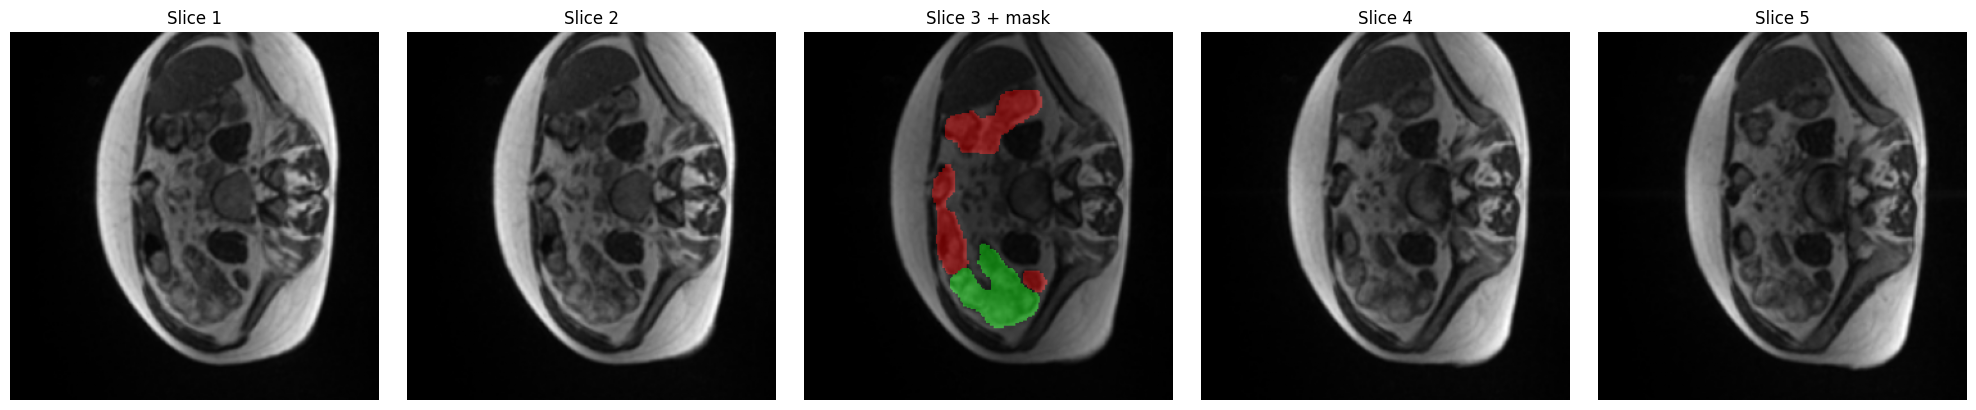

In [104]:
i += 1
images_stack, central_mask, *_ = sanity_check_dataset[i]
images_stack = images_stack.numpy()
central_mask = central_mask.numpy()
central_idx = images_stack.shape[0] // 2

fig, axes = plt.subplots(1, images_stack.shape[0], figsize=(20, 4))
colors = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], dtype=np.float32)
overlay = np.zeros((*central_mask.shape[1:], 3), dtype=np.float32)
for channel, color in zip(central_mask, colors):
    overlay += np.expand_dims(channel, -1) * color

for idx, ax in enumerate(axes):
    ax.imshow(images_stack[idx], cmap="gray")
    title = f"Slice {idx + 1}"
    if idx == central_idx:
        ax.imshow(np.clip(overlay, 0.0, 1.0), alpha=0.4)
        title += " + mask"
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()

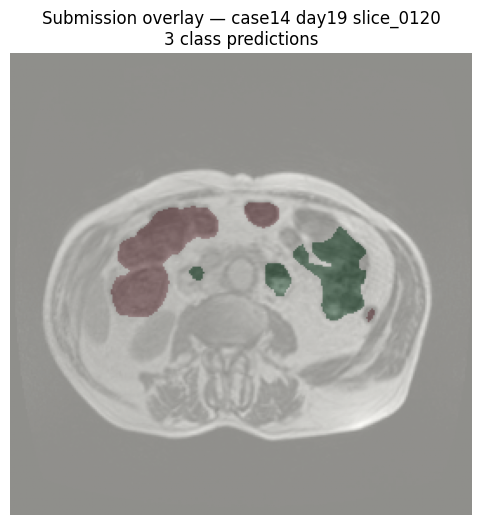

In [157]:
from pathlib import Path

submission_path = Path("submissions/effnet_unetpp_40ep_test_thr_0.8_fixed_shape_v2.csv")
submission_df = pl.read_csv(submission_path).with_columns(
    pl.col("id").str.extract(r"case(\d+)").cast(pl.Int32).alias("case"),
    pl.col("id").str.extract(r"day(\d+)").cast(pl.Int32).alias("day"),
    pl.col("id").str.extract(r"slice_(\d+)").cast(pl.Int32).alias("slice"),
    pl.col("id").str.extract(r"class_(.+)").alias("class"),
)

color_map = {
    "large_bowel": "Reds",
    "small_bowel": "Greens",
    "stomach": "Blues",
}


def load_test_image(case: int, day: int, slice_idx: int) -> tuple[np.ndarray, Path]:
    image_path = (
        Path(test_data_path) / f"case{case}" / f"day{day}" / f"slice_{slice_idx}.png"
    )
    image_uint16 = np.array(Image.open(image_path), dtype=np.float32)
    return preprocess_mri(image_uint16), image_path


def decode_submission_mask(rle: str, image_shape: tuple[int, int]) -> np.ndarray:
    if not rle or rle.strip() == "":
        return np.zeros(image_shape, dtype=np.float32)
    return rle_to_mask(rle, *image_shape).astype(np.float32)


def plot_submission_overlay(case: int, day: int, slice_idx: int) -> None:
    target_rows = submission_df.filter(
        (pl.col("case") == case)
        & (pl.col("day") == day)
        & (pl.col("slice") == slice_idx)
    )

    if target_rows.height == 0:
        raise ValueError("No submission rows found for the requested slice")

    image, image_path = load_test_image(case, day, slice_idx)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image, cmap="gray")

    for row in target_rows.iter_rows(named=True):
        organ_class = row["class"]
        rle = row["segmentation"]
        mask = decode_submission_mask(rle, image.shape)
        if mask.any():
            ax.imshow(mask, cmap=color_map[organ_class], alpha=0.35)

    ax.set_title(
        f"Submission overlay — case{case} day{day} slice_{slice_idx:04d}\n{target_rows.height} class predictions"
    )
    ax.axis("off")
    plt.show()


target_case, target_day, target_slice = 14, 19, 120
plot_submission_overlay(target_case, target_day, target_slice)

---
Final? submission

In [ ]:
def predict_rle_from_loader(
    models: list,
    dataframe_raw: pl.DataFrame,
    dataloader,
    device,
    submission_template,
    thresholds: list = [0.4, 0.5, 0.6, 0.7, 0.8],
    tta: bool = True,
    weights=None,
):
    if not isinstance(models, (list, tuple)):
        models = [models]
    if weights is None:
        weights = [1.0] * len(models)

    for i, m in enumerate(models):
        m.to(device)
        m.eval()
        if tta:
            models[i] = ttach.SegmentationTTAWrapper(
                m, ttach.aliases.d4_transform(), merge_mode="mean"
            )

    classes = ["large_bowel", "small_bowel", "stomach"]

    prediction_storage = {
        f"{mode}_{thr}": [] for mode in ["weighted", "equal"] for thr in thresholds
    }

    id_list = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            if len(batch) == 6:
                images, _, case, day, slice, replay_data = batch
            else:
                images, _, case, day, slice = batch

            images = images.to(device)
            B = images.shape[0]

            probs_list = []
            for m in models:
                logits = m(images)
                probs = torch.sigmoid(logits)
                probs_list.append(probs)

            stacked = torch.stack(probs_list, dim=0)

            weights_tensor = torch.tensor(
                weights, device=device, dtype=stacked.dtype
            ).view(-1, 1, 1, 1, 1)
            avg_probs_weighted = (stacked * weights_tensor).sum(
                dim=0
            ) / weights_tensor.sum()

            avg_probs_equal = stacked.mean(dim=0)

            avg_probs_weighted_np = avg_probs_weighted.cpu().numpy()
            avg_probs_equal_np = avg_probs_equal.cpu().numpy()

            for i in range(B):
                current_case = case[i]
                current_day = day[i]
                current_slice = slice[i]

                for cls_idx, cls_name in enumerate(classes):
                    id_str = f"case{current_case}_day{current_day}_slice_{str(current_slice).zfill(4)}_class_{cls_name}"
                    id_list.append(id_str)

                    prob_map_w = avg_probs_weighted_np[i, cls_idx]
                    prob_map_eq = avg_probs_equal_np[i, cls_idx]

                    for thr in thresholds:
                        mask_w = (prob_map_w > thr).astype(np.uint8)
                        mask_w = post_process_mask(mask_w, (266, 266))
                        rle_w = mask_to_rle(mask_w)
                        prediction_storage[f"weighted_{thr}"].append(rle_w)

                        mask_eq = (prob_map_eq > thr).astype(np.uint8)
                        mask_eq = post_process_mask(mask_eq, (266, 266))
                        rle_eq = mask_to_rle(mask_eq)
                        prediction_storage[f"equal_{thr}"].append(rle_eq)

    output_dataframes = {}

    for key, rle_list in prediction_storage.items():
        pred_df = pl.DataFrame({"id": id_list, "segmentation": rle_list})

        final_df = submission_template.select(["id"]).join(pred_df, on="id", how="left")

        final_df = final_df.with_columns(pl.col("segmentation").fill_null(""))

        output_dataframes[key] = final_df

    return output_dataframes

This one gave by far the best result, even though the improvement in comparison with efficientnet + UNet is not so big
![stacking_weighted](./assets/stacking_weighted.png)

# MedDINOv3
ChatGPT was used to help me write this code.
It cannot be run on apple silicon macbooks. As, to setup [MedDINOv3](https://github.com/ricklisz/MedDINOv3/blob/main/inference/demo.ipynb), some dependencies are x86 only.

In [ ]:

MEDDINO_CHECKPOINT_PATH = Path("external/MedDINOv3/checkpoints/ct_model_vitb_batch_512_adapt_high_res_4999/model.pth")
MEDDINO_REPO_ROOT = Path("external/MedDINOv3")
MEDDINO_MODEL_NAME = "meddino_vitb_unet_decoder_40eps"
MEDDINO_EPOCHS = 40
MEDDINO_BATCH_SIZE = 4
MEDDINO_LR = 2e-4
MEDDINO_WEIGHT_DECAY = 1e-4
MEDDINO_PATIENCE = 6
MEDDINO_FOLDS = 4
MEDDINO_TWO_POINT_FIVE_D = True
MEDDINO_DEPTH = 5
MEDDINO_PATCH_SIZE = 16
MEDDINO_EMBED_DIM = 768
MEDDINO_DECODER_CHANNELS = (256, 128, 64, 32, 16)
MEDDINO_ENCODER_SCALES = (1, 2, 4, 8, 16)
MEDDINO_FREEZE_BACKBONE = True
MEDDINO_SCHEDULER = "cosine"
MEDDINO_VIT_KWARGS = dict(
    drop_path_rate=0.2,
    layerscale_init=1.0e-5,
    n_storage_tokens=4,
    qkv_bias=False,
    mask_k_bias=True,
)


class CombinedDiceBCELoss(nn.Module):
    def __init__(self, dice_weight: float = 0.7, bce_weight: float = 0.3):
        super().__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.dice = smp.losses.DiceLoss(mode="multilabel")
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        return self.dice_weight * self.dice(logits, targets) + self.bce_weight * self.bce(logits, targets)


def _maybe_add_to_sys_path(candidate: Path) -> None:
    if candidate.exists():
        as_str = str(candidate)
        if as_str not in sys.path:
            sys.path.insert(0, as_str)


def load_meddinov3_backbone(
    checkpoint_path: str | Path,
    repo_root: str | Path,
    *,
    device: torch.device,
    vit_kwargs: dict | None = None,
):
    checkpoint_path = Path(checkpoint_path).expanduser()
    repo_root = Path(repo_root).expanduser()

    dinov3_parent = repo_root / "nnUNet" / "nnunetv2" / "training" / "nnUNetTrainer" / "dinov3"
    for path in (repo_root, dinov3_parent):
        _maybe_add_to_sys_path(path)

    try:
        from dinov3.models.vision_transformer import vit_base  # type: ignore
    except ImportError as exc:  
        raise ImportError(
            "dinov3 package not importable. Verify MEDDINO_REPO_ROOT points to the repo root.",
        ) from exc

    vit_cfg = dict(
        drop_path_rate=0.2,
        layerscale_init=1.0e-5,
        n_storage_tokens=4,
        qkv_bias=False,
        mask_k_bias=True,
    )
    if vit_kwargs:
        vit_cfg.update(vit_kwargs)

    backbone = vit_base(**vit_cfg)
    checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only=False)
    state_dict = checkpoint.get("teacher", checkpoint)
    state_dict = {
        k.replace("backbone.", ""): v
        for k, v in state_dict.items()
        if "ibot" not in k and "dino_head" not in k
    }
    missing, unexpected = backbone.load_state_dict(state_dict, strict=False)
    backbone.to(device)
    backbone.eval()
    return backbone


class MedDINOv3Encoder(nn.Module):
    def __init__(
        self,
        model: nn.Module,
        patch_size: int = 16,
        embed_dim: int = 768,
        in_channels: int = 3,
    ):
        super().__init__()
        self.backbone = model
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.in_channels = in_channels
        self.scales = (1, 2, 4, 8, 16)
        if in_channels != 3:
            self.input_adapter = nn.Conv2d(in_channels, 3, kernel_size=1, bias=False)
        else:
            self.input_adapter = nn.Identity()

    def forward(self, x: torch.Tensor) -> list[torch.Tensor]:
        original_hw = x.shape[-2:]
        
        x_adapted = self.input_adapter(x)
        
        tokens = self._prepare_tokens(x_adapted)
        grid_hw = self._infer_grid_hw(tokens)
        tokens = self._run_vit(tokens)
        spatial = self._tokens_to_spatial(tokens, grid_hw)
        
        features = []
        for scale in self.scales:
            target_h = max(1, math.ceil(original_hw[0] / scale))
            target_w = max(1, math.ceil(original_hw[1] / scale))
            
            if spatial.shape[-2:] != (target_h, target_w):
                resized = F.interpolate(
                    spatial, size=(target_h, target_w), mode="bilinear", align_corners=False
                )
            else:
                resized = spatial
            features.append(resized)
            
        return features

    def _prepare_tokens(self, x: torch.Tensor) -> torch.Tensor:
        if hasattr(self.backbone, "prepare_tokens_with_masks"):
            return self.backbone.prepare_tokens_with_masks(x, None)
        if hasattr(self.backbone, "prepare_tokens"):
            return self.backbone.prepare_tokens(x)
        patch_embed = getattr(self.backbone, "patch_embed", None)
        tokens = patch_embed(x)
        if hasattr(self.backbone, "pos_embed"):
            pos_embed = self.backbone.pos_embed
            if tokens.shape[1] == pos_embed.shape[1]:
                tokens = tokens + pos_embed
        if hasattr(self.backbone, "pos_drop"):
            tokens = self.backbone.pos_drop(tokens)
        if hasattr(self.backbone, "cls_token"):
            cls_token = self.backbone.cls_token.expand(tokens.shape[0], -1, -1)
            tokens = torch.cat((cls_token, tokens), dim=1)
        register_tokens = getattr(self.backbone, "register_tokens", None)
        if register_tokens is not None:
            tokens = torch.cat((register_tokens.expand(tokens.shape[0], -1, -1), tokens), dim=1)
        return tokens

    def _run_vit(self, tokens: torch.Tensor) -> torch.Tensor:
        for block in self.backbone.blocks:
            tokens = block(tokens)
        if hasattr(self.backbone, "norm"):
            tokens = self.backbone.norm(tokens)
        return tokens

    def _infer_grid_hw(self, tokens: torch.Tensor) -> tuple[int, int]:
        has_cls = hasattr(self.backbone, "cls_token")
        num_registers = getattr(self.backbone, "num_register_tokens", 0)
        num_storage = getattr(self.backbone, "n_storage_tokens", 0)
        prefix = (1 if has_cls else 0) + num_registers
        spatial_tokens = tokens.shape[1] - prefix - num_storage
        patch_embed = getattr(self.backbone, "patch_embed", None)
        grid_size = getattr(patch_embed, "grid_size", None)
        if grid_size is not None:
            if isinstance(grid_size, tuple):
                return int(grid_size[0]), int(grid_size[1])
            return int(grid_size), int(grid_size)
        side = int(math.sqrt(spatial_tokens))
        return side, max(side, 1)

    def _tokens_to_spatial(self, tokens: torch.Tensor, grid_hw: tuple[int, int]) -> torch.Tensor:
        has_cls = hasattr(self.backbone, "cls_token")
        num_registers = getattr(self.backbone, "num_register_tokens", 0)
        num_storage = getattr(self.backbone, "n_storage_tokens", 0)
        start = (1 if has_cls else 0) + num_registers
        end = tokens.shape[1] - num_storage if num_storage else tokens.shape[1]
        spatial_tokens = tokens[:, start:end, :]
        h, w = grid_hw
        if h * w != spatial_tokens.shape[1]:
            side = int(math.sqrt(spatial_tokens.shape[1]))
            h = w = max(side, 1)
        return spatial_tokens.transpose(1, 2).reshape(tokens.shape[0], self.embed_dim, h, w)


class DINOv3UNet(torch.nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        
        self.decoder = UnetDecoder(
            encoder_channels=(768, 768, 768, 768, 768),
            decoder_channels=(256, 128, 64, 32, 16),
            n_blocks=5,
            attention_type=None
        )
        
        self.segmentation_head = SegmentationHead(
            in_channels=16,
            out_channels=num_classes,
            activation=None,
            kernel_size=3,
        )

    def forward(self, x):
        features = self.encoder(x) 
        
        decoder_output = self.decoder(*features)
        
        masks = self.segmentation_head(decoder_output)
        
        return F.interpolate(masks, size=x.shape[-2:], mode="bilinear", align_corners=False)


def build_meddino_unet_models(device: torch.device, folds_num: int = 4):
    models = []
    loss_fns = []
    optimizers = []
    in_channels = MEDDINO_DEPTH if MEDDINO_TWO_POINT_FIVE_D else 1

    for _ in range(folds_num):
        # Load backbone
        backbone = load_meddinov3_backbone(
            checkpoint_path=MEDDINO_CHECKPOINT_PATH,
            repo_root=MEDDINO_REPO_ROOT,
            device=device,
            vit_kwargs=MEDDINO_VIT_KWARGS,
        )
        
        encoder = MedDINOv3Encoder(
            model=backbone,
            patch_size=MEDDINO_PATCH_SIZE,
            embed_dim=MEDDINO_EMBED_DIM,
            in_channels=in_channels
        )
        
        model = DINOv3UNet(encoder=encoder, num_classes=3).to(device)
        models.append(model)
        loss_fns.append(CombinedDiceBCELoss().to(device))
        optimizers.append(
            optim.AdamW(
                [param for param in model.parameters() if param.requires_grad],
                lr=MEDDINO_LR,
                weight_decay=MEDDINO_WEIGHT_DECAY,
            )
        )
    return models, loss_fns, optimizers


meddino_builder = partial(build_meddino_unet_models)
meddino_unet_models = run_training(
    full_data=train_data_raw_folded,
    model_builder=meddino_builder,
    device=device,
    train_images_path=train_images_path,
    folds_num=MEDDINO_FOLDS,
    epochs=MEDDINO_EPOCHS,
    save_model_path=str(Path("models")),
    model_name=MEDDINO_MODEL_NAME,
    patience=MEDDINO_PATIENCE,
    two_point_five_d=MEDDINO_TWO_POINT_FIVE_D,
    depth=MEDDINO_DEPTH,
    batch_size=MEDDINO_BATCH_SIZE,
    scheduler_type=MEDDINO_SCHEDULER,
)

In [ ]:
def visualize_meddino_inference(model, dataset, device, index=None):
    model.eval()
    
    if index is None:
        index = np.random.randint(len(dataset))
    
    sample = dataset[index]
    image = sample['image'].unsqueeze(0).to(device) 
    mask = sample.get('mask', None) 
    
    print(f"Visualizing sample {index}, Image shape: {image.shape}")

    attention_maps = {}
    hooks = []
    
    def get_attention_hook(name):
        def hook(module, input, output):
            attention_maps[name] = output.detach().cpu()
        return hook

    backbone = model.encoder.backbone
    if hasattr(backbone, 'blocks'):
        for i, block in enumerate(backbone.blocks):
            if hasattr(block, 'attn'):
                if hasattr(block.attn, 'attn_drop'):
                    hooks.append(block.attn.attn_drop.register_forward_hook(get_attention_hook(f'layer_{i}')))
                elif hasattr(block.attn, 'dropout'):
                    hooks.append(block.attn.dropout.register_forward_hook(get_attention_hook(f'layer_{i}')))
    
    with torch.no_grad():
        output = model(image)
        pred_mask = torch.sigmoid(output).cpu().numpy()[0]
    
    for h in hooks:
        h.remove()

    img_vis = image[0].cpu().numpy().transpose(1, 2, 0)
    img_vis = (img_vis - img_vis.min()) / (img_vis.max() - img_vis.min() + 1e-8)
    
    num_classes = pred_mask.shape[0]
    
    cols = num_classes + 1
    fig, axes = plt.subplots(2, cols, figsize=(4 * cols, 8))
    
    axes[0, 0].imshow(img_vis)
    axes[0, 0].set_title("Input Image")
    axes[0, 0].axis('off')
    
    if mask is not None:
        for c in range(num_classes):
            if c < mask.shape[0]:
                axes[0, c+1].imshow(mask[c], cmap='gray')
                axes[0, c+1].set_title(f"GT Class {c}")
                axes[0, c+1].axis('off')
    else:
        for c in range(num_classes):
            axes[0, c+1].text(0.5, 0.5, "No GT", ha='center')
            axes[0, c+1].axis('off')

    axes[1, 0].text(0.5, 0.5, "Predictions ->", ha='center', fontsize=12)
    axes[1, 0].axis('off')
    
    for c in range(num_classes):
        axes[1, c+1].imshow(pred_mask[c], cmap='jet', vmin=0, vmax=1)
        axes[1, c+1].set_title(f"Pred Class {c}")
        axes[1, c+1].axis('off')
        
    plt.tight_layout()
    plt.show()

    if attention_maps:
        print("Visualizing Attention Maps (CLS token attention)...")
        num_layers = len(attention_maps)
        cols = 4
        rows = (num_layers + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
        axes = axes.flatten()
        
        has_cls = hasattr(backbone, "cls_token")
        num_registers = getattr(backbone, "num_register_tokens", 0)
        num_storage = getattr(backbone, "n_storage_tokens", 0)
        prefix = (1 if has_cls else 0) + num_registers
        
        patch_size = model.encoder.patch_size
        h_img, w_img = image.shape[-2:]
        gh, gw = h_img // patch_size, w_img // patch_size
        
        for i in range(num_layers):
            attn = attention_maps[f'layer_{i}'] 
            attn_avg = attn[0].mean(dim=0) 
            
            end_idx = attn_avg.shape[0] - num_storage
            
            if has_cls:
                cls_attn = attn_avg[0, prefix:end_idx]
            else:
                cls_attn = attn_avg[:, prefix:end_idx].mean(dim=0)

            if cls_attn.shape[0] == gh * gw:
                cls_attn = cls_attn.reshape(gh, gw)
                cls_attn_resized = cv2.resize(cls_attn.numpy(), (w_img, h_img), interpolation=cv2.INTER_NEAREST)
                
                axes[i].imshow(img_vis, alpha=0.5)
                axes[i].imshow(cls_attn_resized, cmap='jet', alpha=0.5)
                axes[i].set_title(f"Layer {i}")
            else:
                axes[i].text(0.5, 0.5, f"Shape mismatch\n{cls_attn.shape[0]} vs {gh}x{gw}")
            
            axes[i].axis('off')
            
        for j in range(i+1, len(axes)):
            axes[j].axis('off')
            
        plt.tight_layout()
        plt.show()
    else:
        print("No attention maps captured. Check if hooks were registered correctly.")

print("Building model...")
models, _, _ = build_meddino_unet_models(device, folds_num=1)
inference_model = models[0]

finetuned_checkpoint = Path("models/meddinov3/fold_0.pth")
if finetuned_checkpoint.exists():
    state_dict = torch.load(finetuned_checkpoint, map_location=device)
    inference_model.load_state_dict(state_dict)

if 'val_data' in locals():
    visualize_meddino_inference(inference_model, val_data, device)
elif 'train_data' in locals():
    print("val_data not found, using train_data")
    visualize_meddino_inference(inference_model, train_data, device)
else:
    print("Dataset variables (val_data/train_data) not found.")